## **Problem Set 4: Synthetic Streamflow Generation**
### **Due: Thursday, February 29**

### **Setup**

**Please log into your Stanford Google Drive account when viewing this notebook.** Log in using your SUNetID credentials.

Before we can start Problem Set 4, we need to go through a few minor tasks, as we did in Problem Set 1:
1. Copy Google Colab Notebook (File > Save a copy in Drive)
2. Connect to Github Data Repo
3. Set Up Working Directory

The detailed instructions for the above tasks were provided in Problem Set 1, so we don't need to go through them again here. If you need assistance with any of the above tasks, please refer to Problem Set 1. We'll simply implement Tasks 2 and 3 in the code cell below. In addition, we'll also import all of the libraries we need to complete Problem Set 4.

In [48]:
# Clone github data repository
!git clone https://github.com/sfletcher23/CEE_266F_Data_Repo GitRepo

# set up working directory
import os
wdir = 'GitRepo/Data'
os.chdir(wdir)

# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

Cloning into 'GitRepo'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 79 (delta 29), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (79/79), 786.99 KiB | 3.11 MiB/s, done.
Resolving deltas: 100% (29/29), done.


For this assignment, we recommend that you use the code from class as a starting point: see [Synthetic Generator Demo](https://colab.research.google.com/drive/1i2du-TeCORHVaEdRftyT7HsMS6NNIWwE).

### **Problem 1**: Annual synthetic streamflow generation

In class we developed synthetic streamflow time series for annual streamflow at Folsom Reservoir to estimate
the frequency of multi-year droughts using thomas fiering method, as in [Synthetic Generator Demo](https://colab.research.google.com/drive/1i2du-TeCORHVaEdRftyT7HsMS6NNIWwE).  Here you will apply
the same method to the South River near Waynesboro, VA (USGS Gage 01626000) using data in the
’SouthRiver_Waynesboro.csv’ file

In [49]:
# load data of daily flow data from South River
dailyQ = pd.read_csv('SouthRiver_Waynesboro.csv')


In [50]:
#preprocessing: Calculate annual maxima from daily data

# convert first column to date
dailyQ['Date'] = pd.to_datetime(dailyQ['Date'],format="%Y-%m-%d")
dailyQ['Flow'] = pd.to_numeric(dailyQ['Flow'],errors='ignore')

# find year of each data point
dailyQ['Year'] = dailyQ['Date'].dt.year
years = np.unique(dailyQ['Year'])

# Delete leap days
dailyQ = dailyQ[~((dailyQ.Date.dt.month == 2) & (dailyQ.Date.dt.day == 29))]

# Fill in nan values
dailyQ = dailyQ.fillna(method='ffill')

# Get annual flow
annQ = np.array(dailyQ.groupby('Year').mean()['Flow'])

<ipython-input-50-7dc50e81ba1d>:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  annQ = np.array(dailyQ.groupby('Year').mean()['Flow'])


In [51]:
#functions
def autocorr(x,k):
    '''returns the lag-k autocorrelation of vector x'''
    x = x.reshape(-1,1)
    return sm.tsa.acf(x)[1]

def thomasfiering(x, T, N, seed):
    '''Lag-1 model. use historical data x
    to generate N synthetic sequences of T timesteps.
    Assumes x is lognormally distributed.'''
    # Set random seed
    np.random.seed(seed)
    # Log transform of data
    x = np.log(x) # log-space avoids negative values
    # Calculate mean, variance, lag-1 autocorrelation
    mu = x.mean()
    sigma = x.std()
    rho = autocorr(x,1)
    # Note the retransformation bias in rho
    # Initialize the a N x T matrix where you will save streamflow values
    Q = np.zeros([N, T])
    Q[:, 0] = np.random.normal(mu,sigma,1) # Choose starting value
    # Loop over time, and simulate AR(1) for each
    # Note instead of looping over N, we vectorize
    for i in range(1, T):
        Z = np.random.standard_normal(N)
        Q[:, i] = mu + rho*(Q[:, i-1] - mu) + Z*sigma*np.sqrt(1-rho**2)
    return np.exp(Q)

**Part A**: Apply the Thomas Fiering / AR(1) method to the South River to generate 10 realizations of a 200-year
time series. Set the random seed at 5. Report the mean, standard deviation, and lag-1 autocorrelation
of both the historical record and the synthetic timeseries. Plot the synthetic timeseries with the
historical time series overlaid

Means: 151.144904, 151.868168
Stdev: 60.332552, 61.822115
Rho: 0.043306, 0.066737


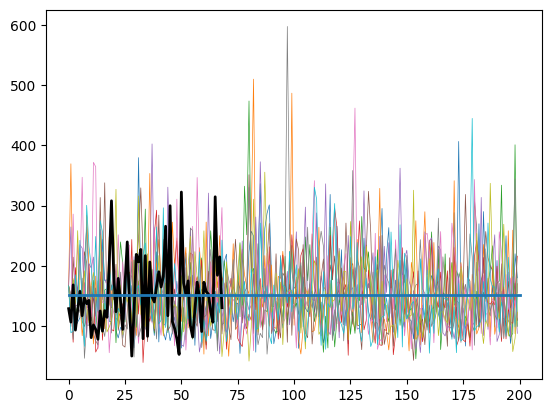

In [52]:
# Part A
Q_synthetic = thomasfiering(annQ, T=200, N=10, seed=5)

print('Means: %f, %f' % (annQ.mean(),Q_synthetic.mean()))
print('Stdev: %f, %f' % (annQ.std(),Q_synthetic.std()))
print('Rho: %f, %f' % (autocorr(annQ,1), autocorr(Q_synthetic,1)))

plt.set_cmap('gray')
plt.plot(np.transpose(Q_synthetic), linewidth=.5)
plt.plot(annQ, color='black', linewidth=2)
plt.plot([0,200], [annQ.mean(), annQ.mean()], linewidth=2)
plt.show()

**Part B**: Use the results from a) to estimate the average return period of a 4-year drought, where a drought
year is defined as having less than 80% of the historical mean annual streamflow.

In [53]:
# Part B
threshold = annQ.mean() * .8
droughtLen = 4

def multi_year_drought_freq(Q, threshold, droughtLen):
  '''Count the average number of droughts that are at least as long as droughLen
    in each streamflow timeseries Q.
    Q can either be a N x T matrix or a vector with a single time series of length T'''

  # Get N and T from Q - the try except is used to handle either matrix or vector input
  try:
    T = np.shape(Q)[1]
    N = len(Q)
  except:
    N = 1
    T = len(Q)

  # If N = 1, turn vector into 2D matrix so indexing workds
  if N == 1:
    Q = Q.reshape(1, -1)

  # Initialize vector to save number of multi year droughts in each time series
  numNYrDrought = np.zeros(N)

  # Loop over each time series (could vectorize this to improve speed)
  for i in range(N):

    # Get vector for a single time series
    Q_now = Q[i,:]

    # Find which values are below the drought threshold - True means drought
    below = Q_now < threshold

    # Count the length of each consecutive set of true values (just trust me it works)
    consecTrue = np.diff(np.where(np.concatenate(([below[0]], below[:-1] != below[1:], [True])))[0])[::2]

    # Count the number of consecutive drought occurences with at least minimum length
    numNYrDrought[i] = np.sum(consecTrue >= droughtLen)

  # Average number of three year droughts over all the time series
  avgNYrDrought = np.mean(numNYrDrought)

  return avgNYrDrought, T

avgNYrDrought, T = multi_year_drought_freq(Q_synthetic, threshold, droughtLen)
print('On average, a {}-year drought occurs {} times in a {} year period'.format(droughtLen, avgNYrDrought, T))
print('Return period', T/avgNYrDrought)

avgNYrDrought, T = multi_year_drought_freq(annQ.T, threshold, droughtLen)
print('A {}-year drought occured {} times in the {}-year historical record'.format(droughtLen, avgNYrDrought, T))
print('Return period', T/avgNYrDrought)

On average, a 4-year drought occurs 2.7 times in a 200 year period
Return period 74.07407407407408
A 4-year drought occured 2.0 times in the 69-year historical record
Return period 34.5


**Part C**: Repeat b) using 1000 realizations and report the estimated average return period. Is your estimate
higher or lower than the estimate using only 10 realizations? Why do you think that is?

In [54]:
# Part C
Q_synthetic = thomasfiering(annQ, T=200, N=1000, seed=5)
avgNYrDrought, T = multi_year_drought_freq(Q_synthetic, threshold, droughtLen)
print('On average, a {}-year drought occurs {} times in a {} year period'.format(droughtLen, avgNYrDrought, T))
print('Return period:', T/avgNYrDrought)

On average, a 4-year drought occurs 2.434 times in a 200 year period
Return period: 82.16926869350863


My estimation is higher than using only 10 realizations due to increased sampling variability, poorer capture of the autocorrelation structure, and lower statistical confidence in the estimates derived from a smaller sample size.


**Part D**: We would like our estimate of the return period (in years) to be accurate to the nearest integer. Is
1000 realizations sufficient to reach this level of convergence? [Hint: change the random seed.]

In [55]:
# Part D
avgNYrDroughtCtn=[]
avgNYrDroughtCtn2=[]

for i in range(10):
  Q_synthetic = thomasfiering(annQ, T=200, N=10, seed=i)
  avgNYrDrought, T = multi_year_drought_freq(Q_synthetic, threshold, droughtLen)
  avgNYrDroughtCtn.append(T/avgNYrDrought)
print(avgNYrDroughtCtn)
print('variance:',np.var(avgNYrDroughtCtn))

for i in range(10):
  Q_synthetic = thomasfiering(annQ, T=200, N=1000, seed=i)
  avgNYrDrought, T = multi_year_drought_freq(Q_synthetic, threshold, droughtLen)
  avgNYrDroughtCtn2.append(T/avgNYrDrought)
print(avgNYrDroughtCtn2)
print('variance:',np.var(avgNYrDroughtCtn2))

[64.51612903225806, 100.0, 80.0, 50.0, 58.82352941176471, 74.07407407407408, 111.11111111111111, 71.42857142857143, 80.0, 64.51612903225806]
variance: 309.71284057314176
[82.88437629506839, 79.6812749003984, 79.14523149980214, 78.15552950371239, 81.56606851549755, 82.16926869350863, 80.8080808080808, 82.50825082508251, 80.25682182985554, 82.16926869350863]
variance: 2.269685684927738


As the realization number increase to 1000, the variance of return period decrease to 2.27 compared to 309.71 for 100 realization, indicating 1000 realizations are sufficient since it address the sampling error.

### **Problem 2**: K-nn method for daily disaggregation

Now you will apply the K-nn method for daily disaggregation to the Thomas-Fiering annual estimates using
the script ’Daily_AR1_Knn.py’. Use the same dataset as problem 1.


**Part A**: Using one 200-year realization of synthetic annual flows from the AR(1) model, apply the K-nn daily
disaggregation approach. Make one plot of the synthetic daily flows as a function of the day of year,
and another plot with the historical daily flows as a function of the day of year

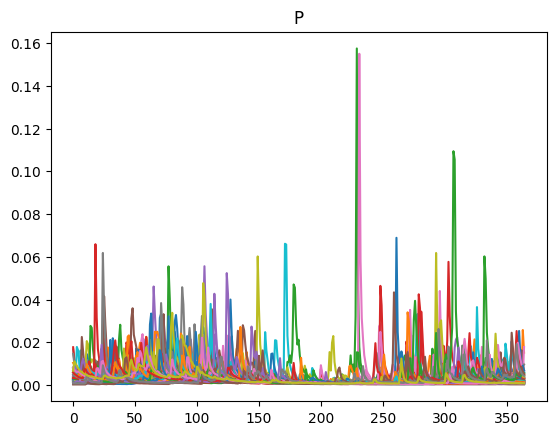

In [64]:
# Part A

# Use Thomas Fiering to simulate an annual flow time series based on historical
annQsyn = thomasfiering(annQ, T=200, N=1, seed = 4)
annQsyn = annQsyn[0]

dailyQMatrix = np.array(dailyQ['Flow']).reshape(-1, 365)

# Calculate annual sum i.e. sum of each row
annSum = np.sum(dailyQMatrix, 1)

# Normalize daily values by annual value
P = dailyQMatrix / annSum[:, None]

# Check that daily values sum to one
tol = .0001
assert np.sum(np.abs(np.sum(P, 1) - 1) > tol) == 0, 'rows should sum to 1'

plt.figure()
plt.plot(P.T)
plt.title('P')
plt.show()

N = len(annQ)

# Choose K as sqrt of N following Lall and Sharma 1996
k = int(np.sqrt(N))

# Initialize
dailyQResampled = np.zeros([N, 365])

In [66]:
print(len(annQ))


69


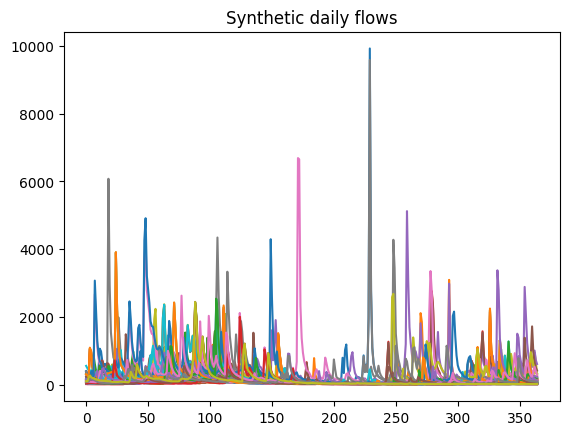

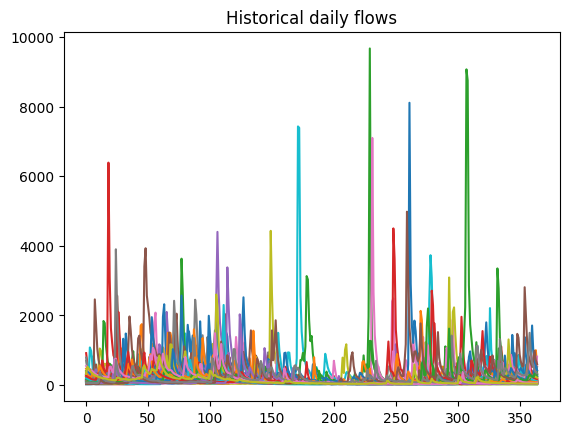

In [67]:
for i in range(N):

    # For the current synthetic value, find the indicies of the
    # k nearest neighbors in the historical record
    kNN_ind = np.argsort(np.abs(annQsyn[i] - annQ))[0:k]

    # Calculate the weights and check they sum to 1
    W = [(1/i) / np.sum(1 / np.arange(1,k+1)) for i in np.arange(1,k+1)]
    # Sample a year from historical reocrd with weights W
    cumW = np.cumsum(W)
    rnd = np.random.rand()
    samp_ind = kNN_ind[np.where(rnd < cumW)[0][0]]

    # Get daily proportion series from sampled year and use to disaggregate
    # annual synthetic flow to daily flow
    dailyQResampled[i,:] = annQsyn[i] * P[samp_ind, :] * 365

  # %% Plot synthetic daily flows

meanDailyQ = np.mean(np.array(dailyQ['Flow']).reshape(365,-1),1)
plt.figure()
plt.plot( dailyQResampled.T)
plt.title('Synthetic daily flows')

plt.figure()
plt.plot( dailyQMatrix.T )
plt.title('Historical daily flows')
plt.show()

**Part B**: Make ACF and PACF plots of both the historical and synthetic daily flows.

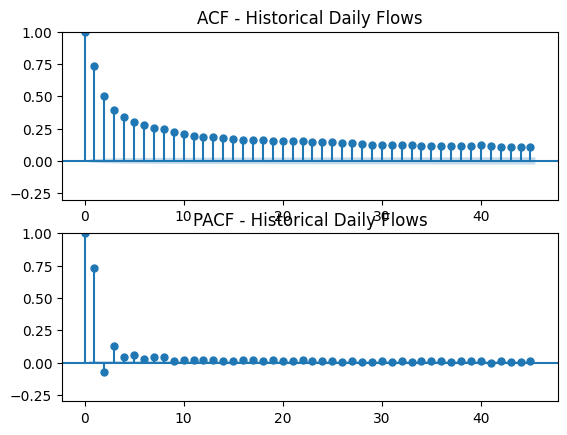

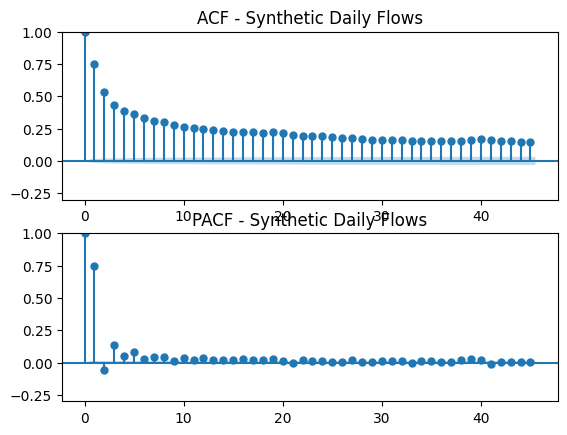

In [80]:
# Part B
fig = plt.figure()

# Historical daily flows
ax = fig.add_subplot(2,1,1)
sm.graphics.tsa.plot_acf(dailyQ['Flow'], ax=ax, title='ACF - Historical Daily Flows')
ax.set_ylim(-0.3, 1)

ax = fig.add_subplot(2,1,2)
sm.graphics.tsa.plot_pacf(dailyQ['Flow'], ax=ax, title='PACF - Historical Daily Flows')
ax.set_ylim(-0.3, 1)

fig = plt.figure()

# Synthetic daily flows
ax = fig.add_subplot(2,1,1)
sm.graphics.tsa.plot_acf(dailyQResampled.reshape(-1,1), ax=ax, title='ACF - Synthetic Daily Flows')
ax.set_ylim(-0.3, 1)
ax = fig.add_subplot(2,1,2)
sm.graphics.tsa.plot_pacf(dailyQResampled.reshape(-1,1), ax=ax, title='PACF - Synthetic Daily Flows')
ax.set_ylim(-0.3, 1)

plt.show()





**Part C**: Based on the plots from a) and b), do you think we have done a good job of preserving the seasonality
and autocorrelation of the daily data? Why does the k-NN method lead to this result?

**Answer**: The ACF and PACF plots of the synthetic data closely resemble those of the historical data, it suggests that the seasonality and autocorrelation patterns have been preserved reasonably well. The k-NN method aims to preserve the statistical properties of the historical data by resampling from the nearest neighbors in the historical record. It works by finding the k-nearest neighbors to the current synthetic value and then sampling from those neighbors based on certain weights. This approach is designed to maintain the statistical characteristics of the original data, including seasonality and autocorrelation.

**Part D**: Would an AR(1) model applied directly to the daily flows capture the daily autocorrelation pattern
as accurately as the K-nn method? Why or why not?

**Answer**: No it would not. According to ACF and PACF plots, there are more than 1 lag that are significant, so AR(1) cannot acpture the daily autocorrelation.


**Important Notes on handing in your problem set:**

1. Please save your Google Colab notebook as a PDF by following the instructions posted on Canvas- Modules-Week3-Convert Notebook to Pdf.pdf. Next, hand in your assignment by uploading your pdf to Gradescope. Alternatively, you could follow Method 1 from this [video tutorial](https://www.youtube.com/watch?v=-Ti9Mm21uVc).
2. To help with grading, please make sure your Google Collab Notebook is shared (with edit access) with Mofan (mofanz@stanford.edu) and Aniket (aniketv@stanford.edu). In addition, please include the full link of your notebook here: {}.